In [6]:
import os
from src.utils.utils_json import *
models = [
    "fcb_7"
]

reports = {}

for model in models:
    filename = os.path.join("reports", f"{model}.json")
    data = read_json(filename)

    if "model_name" not in data:
        data["model_name"] = model

    reports[model] = data

In [7]:
# This needs to be imported because the model uses a custom classes that need to be registered
from src.sketch_detection_rcnn.roi_heads import SketchROIHeads  # noqa # pylint: disable=unused-import
model_name = 'fcb_7'
model_meta = reports[model_name]
print(model_meta)



{'config_file': 'models/fcb_7/cfg.json', 'date': '2023-11-28 07:51:27', 'inference': {'bbox': {'AP': 85.09128056837034, 'AP-arrow': 69.57841730118957, 'AP-connection': 87.1758020959677, 'AP-data': 96.08030106063022, 'AP-decision': 88.38571116503891, 'AP-process': 77.35718544016481, 'AP-terminator': 88.2109408187979, 'AP-text': 88.85060609680333, 'AP50': 99.39241926512057, 'AP75': 97.50764047630153, 'APl': 85.79606692570654, 'APm': 70.64611508433808, 'APs': nan}}, 'metrics_file': 'models/fcb_7/metrics.json', 'model_name': 'fcb_7', 'model_path': 'models/fcb_7', 'training_data': 'datasets/fcb', 'training_time': 20186.79780435562}


In [8]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_meta["config_file"])

# path to the model we just trained
cfg.MODEL.WEIGHTS = os.path.join("models", model_name, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4  # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [9]:
from src.dataset.dataset import read_dateset_from

validation_dataset = read_dateset_from(model_meta["training_data"], "train")

In [10]:
import cv2
import torch

from typing import Tuple
from detectron2.utils.visualizer import Visualizer
from src.visualization.visualize import show_img
from src.utils.utils_bbox import bbox_iou

example_gt = validation_dataset[1]

# Set threshold for bounding box matching (IoU)
bbox_threshold = 0.75

im = cv2.imread(example_gt["file_name"])
example_prediction = predictor(im)

/root/miniconda3/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Ground truth


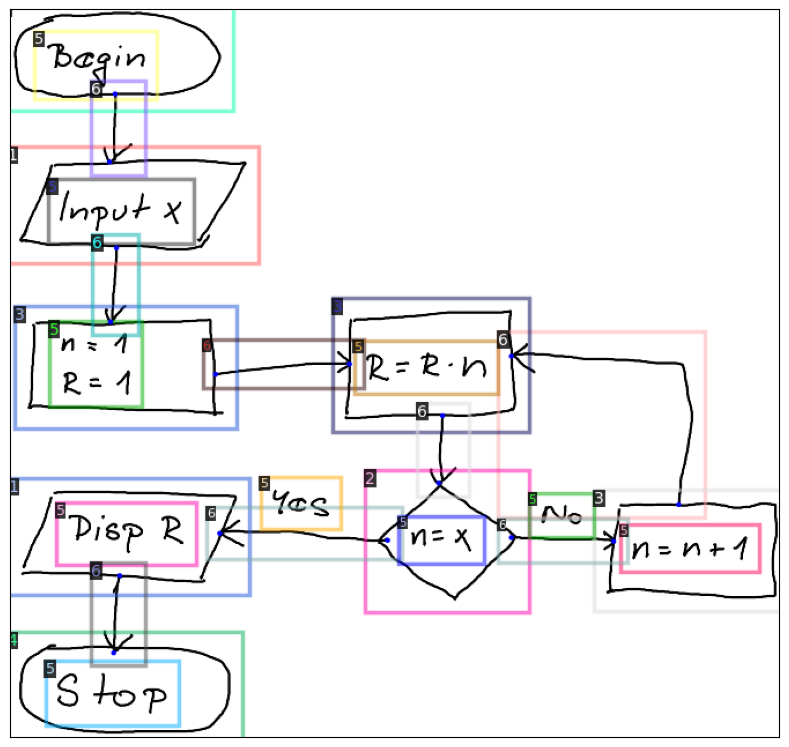

Predictions
Instances(num_instances=26, image_height=1261, image_width=1333, fields=[pred_boxes: Boxes(tensor([[6.0724e+01, 1.1295e+03, 2.9185e+02, 1.2417e+03],
        [7.9273e+01, 8.5365e+02, 3.2046e+02, 9.6288e+02],
        [4.0946e+01, 3.9305e+01, 2.5367e+02, 1.5702e+02],
        [6.7226e+02, 8.7990e+02, 8.1819e+02, 9.6022e+02],
        [1.3927e+02, 9.5930e+02, 2.3263e+02, 1.1370e+03],
        [3.3973e+02, 8.6400e+02, 6.7196e+02, 9.5429e+02],
        [1.0542e+03, 8.9341e+02, 1.2936e+03, 9.7602e+02],
        [4.3338e+02, 8.1196e+02, 5.7073e+02, 8.9951e+02],
        [8.9698e+02, 8.3778e+02, 1.0101e+03, 9.1440e+02],
        [8.4410e+02, 8.8361e+02, 1.0662e+03, 9.5937e+02],
        [8.4469e+02, 5.5877e+02, 1.2026e+03, 8.8373e+02],
        [5.9584e+02, 5.7537e+02, 8.4476e+02, 6.6740e+02],
        [6.6495e+01, 5.4050e+02, 2.2790e+02, 6.8991e+02],
        [1.3819e+02, 1.2530e+02, 2.3176e+02, 2.8910e+02],
        [0.0000e+00, 0.0000e+00, 3.8058e+02, 1.7708e+02],
        [1.4135e+02, 3.9041

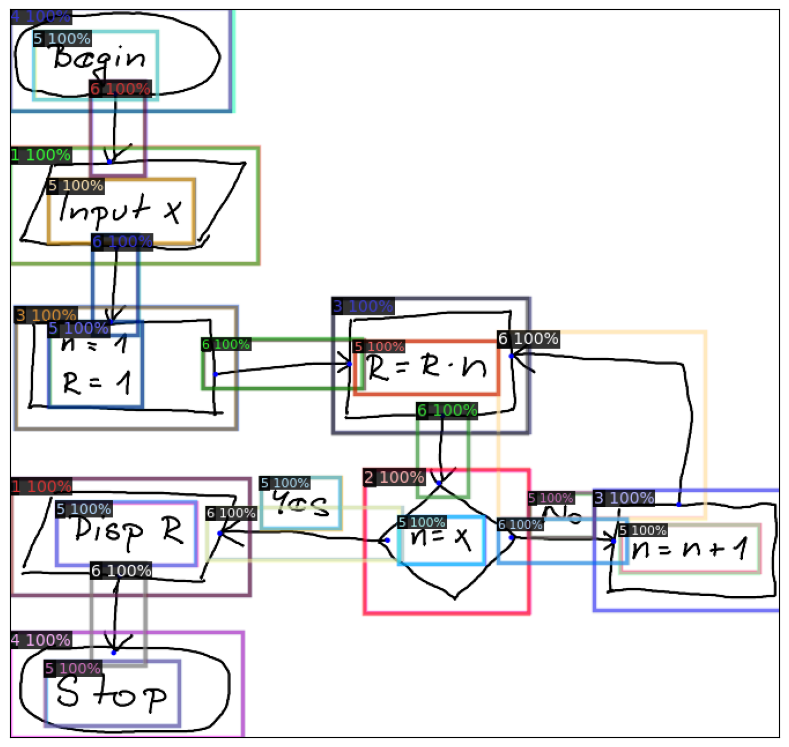

arrow_keypoints
--------------------------
bbox tensor(139.2687) tensor(959.3025) tensor(232.6275) tensor(1136.9895)
w h center_x center_y tensor(93.3588) tensor(177.6870) tensor(185.9481) tensor(1048.1460)
arrow_ab 162 966 161 992
arrow_rela tensor(-0.2475) tensor(-0.4598) tensor(-0.2653) tensor(-0.3127)
True
True
--------------------------
bbox tensor(339.7334) tensor(864.0026) tensor(671.9551) tensor(954.2906)
w h center_x center_y tensor(332.2217) tensor(90.2880) tensor(505.8443) tensor(909.1466)
arrow_ab 513 869 343 868
arrow_rela tensor(0.0236) tensor(-0.4342) tensor(-0.4901) tensor(-0.4554)
True
True
--------------------------
bbox tensor(844.0995) tensor(883.6127) tensor(1066.1989) tensor(959.3697)
w h center_x center_y tensor(222.0993) tensor(75.7570) tensor(955.1492) tensor(921.4912)
arrow_ab 841 887 884 887
arrow_rela tensor(-0.5102) tensor(-0.4497) tensor(-0.3188) tensor(-0.4489)
False
True
--------------------------
bbox tensor(844.6915) tensor(558.7722) tensor(1202.6444) 

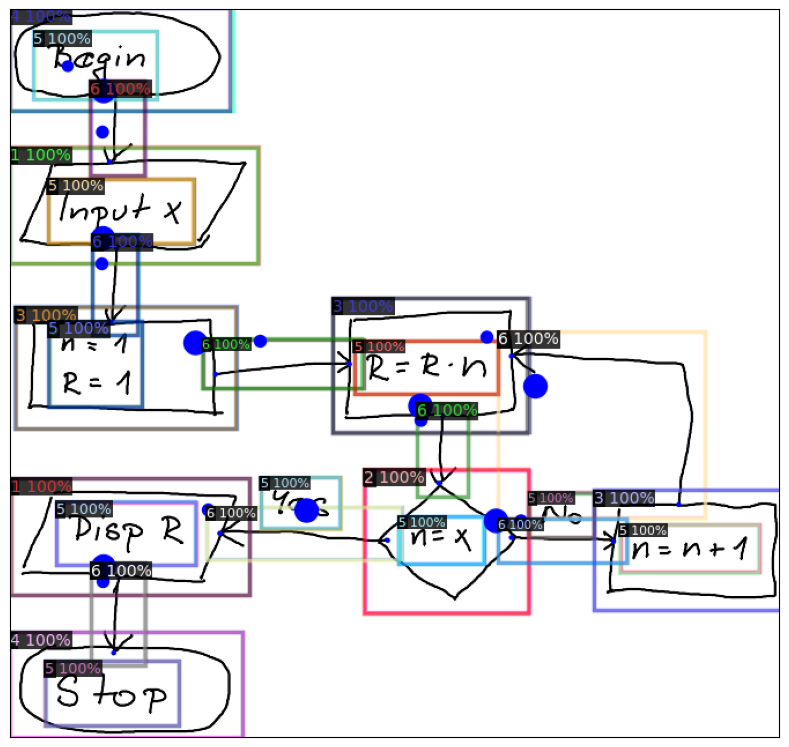

In [11]:
from pprint import pprint
# remove the colors of unsegmented pixels. This option is only available for segmentation models
visualizer = Visualizer(im, scale=0.5)

print("Ground truth")
gt_out = visualizer.draw_dataset_dict(example_gt)
show_img(gt_out.get_image())
# pprint(example_gt)

print("Predictions")
pred_out = visualizer.draw_instance_predictions(example_prediction["instances"].to("cpu"))
print(example_prediction["instances"].to("cpu"))
show_img(pred_out.get_image())

print("arrow_keypoints")
predictions = example_prediction["instances"].to("cpu")

for bbox, pred_arrow,cls in zip(predictions.pred_boxes, predictions.pred_arrow_keypoints,predictions.pred_classes):
    l_x, l_y, r_x, r_y = bbox
    s_x_r, s_y_r, e_x_r, e_y_r = pred_arrow
    if cls!=6:
        continue
    w = r_x - l_x
    h = r_y - l_y
    center_x = l_x + w / 2
    center_y = l_y + h / 2
    s_x = s_x_r * w + center_x 
    s_y = s_y_r * h + center_y 
    e_x = e_x_r * w + center_x 
    e_y = e_y_r * h + center_y 
    # 如果s_x小于0或者大于图像的宽度，那么就设置为0或者图像宽度
    def fix_coord(coord, max_coord):
        if coord < 0:
            return 0
        if coord > max_coord:
            return max_coord
        return int(coord)

    s_x = fix_coord(s_x, im.shape[1])
    s_y = fix_coord(s_y, im.shape[0])
    e_x = fix_coord(e_x, im.shape[1])
    e_y = fix_coord(e_y, im.shape[0])

    def isInbbox(x, y, bbox):
        l_x, l_y, r_x, r_y = bbox
        if x > l_x and x < r_x and y > l_y and y < r_y:
            return True
        return False
    print("--------------------------")
    print("bbox",l_x, l_y, r_x, r_y)
    print("w h center_x center_y",w,h,center_x,center_y)
    print("arrow_ab",s_x, s_y, e_x, e_y)
    print("arrow_rela",s_x_r, s_y_r, e_x_r, e_y_r)

    print(isInbbox(s_x, s_y, bbox))
    print(isInbbox(e_x, e_y, bbox))

    circle_out = visualizer.draw_circle(circle_coord = [s_x,s_y],color = '#FF0000',radius = 20)
    circle_out = visualizer.draw_circle(circle_coord = [e_x,e_y],color = '#FF0000',radius = 10)
    
    # arrow_pixel_positions.append([s_x, s_y, e_x, e_y])


circle_out = visualizer.draw_circle(circle_coord = [100,100],color = '#FF0000',radius = 9)
show_img(circle_out.get_image())


In [12]:
predictions = example_prediction["instances"].to("cpu")
print("predictions bbox:",predictions.pred_boxes)
print("predictions classes:",predictions.pred_classes)
print("predictions scores:",predictions.scores)
print("predictions pred_arrow:",predictions.pred_arrow_keypoints)

predictions bbox: Boxes(tensor([[6.0724e+01, 1.1295e+03, 2.9185e+02, 1.2417e+03],
        [7.9273e+01, 8.5365e+02, 3.2046e+02, 9.6288e+02],
        [4.0946e+01, 3.9305e+01, 2.5367e+02, 1.5702e+02],
        [6.7226e+02, 8.7990e+02, 8.1819e+02, 9.6022e+02],
        [1.3927e+02, 9.5930e+02, 2.3263e+02, 1.1370e+03],
        [3.3973e+02, 8.6400e+02, 6.7196e+02, 9.5429e+02],
        [1.0542e+03, 8.9341e+02, 1.2936e+03, 9.7602e+02],
        [4.3338e+02, 8.1196e+02, 5.7073e+02, 8.9951e+02],
        [8.9698e+02, 8.3778e+02, 1.0101e+03, 9.1440e+02],
        [8.4410e+02, 8.8361e+02, 1.0662e+03, 9.5937e+02],
        [8.4469e+02, 5.5877e+02, 1.2026e+03, 8.8373e+02],
        [5.9584e+02, 5.7537e+02, 8.4476e+02, 6.6740e+02],
        [6.6495e+01, 5.4050e+02, 2.2790e+02, 6.8991e+02],
        [1.3819e+02, 1.2530e+02, 2.3176e+02, 2.8910e+02],
        [0.0000e+00, 0.0000e+00, 3.8058e+02, 1.7708e+02],
        [1.4135e+02, 3.9041e+02, 2.2080e+02, 5.6467e+02],
        [6.5606e+01, 2.9424e+02, 3.1514e+02, 4.0

In [13]:
print("predictions pred_arrow len:",len(predictions.pred_arrow_keypoints))
print("predictions bbox len:",len(predictions.pred_boxes))

predictions pred_arrow len: 26
predictions bbox len: 26


In [14]:
arrow_pixel_positions = []
for bbox, pred_arrow in zip(predictions.pred_boxes, predictions.pred_arrow_keypoints):
    l_x, l_y, r_x, r_y = bbox
    s_x_r, s_y_r, e_x_r, e_y_r = pred_arrow

    s_x = s_x_r * (r_x - l_x) + (l_x + r_x) / 2
    s_y = s_y_r * (r_y - l_y) + (l_y + r_y) / 2
    e_x = e_x_r * (r_x - l_x) + (l_x + r_x) / 2
    e_y = e_y_r * (r_y - l_y) + (l_y + r_y) / 2

    arrow_pixel_positions.append([s_x, s_y, e_x, e_y])

arrow_pixel_positions


[[tensor(114.5768), tensor(1151.1473), tensor(110.2125), tensor(1149.8448)],
 [tensor(131.7169), tensor(876.2344), tensor(118.0087), tensor(873.1681)],
 [tensor(107.7004), tensor(70.1940), tensor(84.6856), tensor(78.5503)],
 [tensor(694.1642), tensor(893.2109), tensor(692.8106), tensor(889.8995)],
 [tensor(162.8417), tensor(966.4473), tensor(161.1796), tensor(992.5746)],
 [tensor(513.6925), tensor(869.9465), tensor(343.0259), tensor(868.0326)],
 [tensor(1127.1863), tensor(911.4449), tensor(1093.8999), tensor(913.0161)],
 [tensor(466.4557), tensor(833.0347), tensor(451.7300), tensor(829.8533)],
 [tensor(909.0322), tensor(847.7322), tensor(909.1944), tensor(846.0372)],
 [tensor(841.8387), tensor(887.4255), tensor(884.3400), tensor(887.4847)],
 [tensor(909.4978), tensor(654.5599), tensor(825.1638), tensor(569.7325)],
 [tensor(665.5654), tensor(600.3020), tensor(633.6224), tensor(598.5298)],
 [tensor(114.5926), tensor(574.8957), tensor(105.3348), tensor(573.6256)],
 [tensor(162.6974), tens

In [15]:
print(pred_out.get_image().shape)

(630, 666, 3)
